In [1]:
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp

# `qiskit_algorithms`  

[Qiskit Algorithms 0.2.1](https://qiskit.org/ecosystem/algorithms/tutorials/01_algorithms_introduction.html)

# Introduction to Algorithms using Qiskit

Examples of algorithms: 
* `Minimum Eigensolvers` is used to find the smallest eigenvalue of an operator. For example, the minimum eigenvalue of the Hamiltonian operator is the ground state energy.
* `Time Evolvers` as the name suggests, is for the time evolution of a quantum system
* `Amplitude estimators` which I assume is used to estimate the probability for a quantum system to be in a certain state.

## The Variational Quantum Eigensolver (VQE)
Given a Hilbert Space and a Hamiltonian $H$ over it. 
We consider the eigenbasis $\{\ket{\psi_\lambda}\}$ where $\langle\psi_{\lambda_1}\vert\psi_{\lambda_2}\rangle = \delta_{\lambda_1 \lambda_2}$  
The eigenvectors satisfy the eigenvalue equation
$$
H\ket{\psi_\lambda} = E_\lambda \ket{\psi_\lambda}
$$
Suppose one wants to calculate the ground state energy $E_\text{gs}$, the **variational principle** will give an *upper bound* for $E_\text{gs}$ i.e. $E_\text{gs} \leq \bra{\phi}H\ket{\phi}\equiv \langle H \rangle$  
Here $\ket{\phi}$ is an arbitrary **normalized** quantum state, it is evidently true when $\ket{\phi}$ is one of the eigenstates of $H$.  
**Proof**
$$
\begin{gather*}
\ket{\phi} = \sum_\lambda C_\lambda \ket{\phi_\lambda} \\
\sum_i \left(C_i^* \bra{\psi_i} \sum_j C_j \ket{\psi_j}\right)
=\sum_i\sum_j C_i^* C_j \langle{\psi_i}\vert{\psi_j}\rangle
= \sum_i\sum_j C_i^*C_j \delta_{ij} = \sum_\lambda |C_\lambda|^2
=\mathrm{I} \\
\braket{H} = \sum_i \left( C_i^* \bra{\psi_i} H \sum_j C_j \ket{\phi_j}\right)
=\sum_i \sum_j C_i^* C_j E_j \braket{\psi_i\vert\psi_j}
=\sum_i E_i|C_i|^2
\end{gather*}
$$
By definition, the ground state energy $E_\text{gs}$ is the smallest eigenvalue of $H$
, thus $\braket{H} \geq E_\text{gs}\sum_i |C_i|^2 = E_\text{gs}$ is satisfied. 

Based on the variational principle, the VQE tests parametrized trial wave functions, and attempts to find the minimum value using optimization methods.

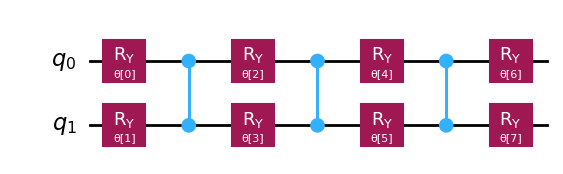

In [2]:
from qiskit import *
from qiskit_algorithms.optimizers import SLSQP
from qiskit.circuit.library import TwoLocal

num_qubits = 2
ansatz = TwoLocal(num_qubits, "ry", "cz")
optimizer = SLSQP(maxiter=1000) 
ansatz.decompose().draw("mpl", style="iqx")

### `TwoLocal` circuit
> [IBM Quantum Documentation](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.TwoLocal)  
 
The two-local circuit is a parametrized circuit consisting of alternating rotation layers and entanglement layers.
The rotation layers are single qubit gates applied on all qubits.
The entanglement layers uses two-qubit gates to entangle the qubits according to a strategy set using `entanglement`
In the example a rotation about the $y$ axis is performed, and a controlled z-gate is used to entangle the qubit pair.
* Controlled Z gate (`cz`):
$$
\begin{align*}
CZ q_0q_1 &= \mathrm{I}\otimes\ket{0}\bra{0} + \sigma_z \ket{1}\bra{1}\\
&= 
\begin{pmatrix}
1 & 0 \\
0 & 1
\end{pmatrix}
\otimes
\begin{pmatrix}
1\\0
\end{pmatrix}
\begin{pmatrix}
1 & 0
\end{pmatrix}
+
\begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}
\otimes
\begin{pmatrix}
0\\1
\end{pmatrix}
\begin{pmatrix}
0 & 1
\end{pmatrix}
=
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 &-1
\end{pmatrix}
\end{align*}
$$
As shown in the circuit diagram, the pair of qubits are undergo $y$ rotations followed by `cz` entanglement operation.
The default parameter for `reps` is 3, and `skip_final_rotation_layer` is `false` if unspecified.
This circuit consists of a total of 9 $y$ rotation gates, each angle is a parameter subject to optimization in the `SLSQP` algorithm. 

## Executing the algorithm

In [3]:
from qiskit.primitives import Estimator
from qiskit_algorithms import VQE
from qiskit.quantum_info import SparsePauliOp
estimator = Estimator()
vqe = VQE(estimator, ansatz, optimizer)
H2_op = SparsePauliOp.from_list([
    ("II", -1.052373245772859),
    ("IZ", 0.39793742484318045),
    ("ZI", -0.39793742484318045),
    ("ZZ", -0.01128010425623538),
    ("XX", 0.18093119978423156)
])

The `ansatz` TwoLocal circuit is the trial quantum state with 7 $\theta_i$ parameters for $R_{y}^{(i)}(\theta_i)$.   
The objective is to find the ground state of some given Hamiltonian via VQE numerical method.  
The current setup of the VQE algorithm is to implement the `SLSQP` classical optimizer.  
To test the VQE, the following demonstration aims to solve for the ground state energy of the electron pair in a hydrogen molecule.

### Hamiltonian of a Hydrogen molecule
`SparsePauliOp` is a sparse N-qubit operator constructed by Pauli matrices
In this example, we have two qubits, and the sparse operator is a linear combination of 5 bipartite operations:
1. `II` $ = \mathrm{I} \otimes \mathrm{I}$
2. `IZ` $ = \mathrm{I} \otimes \sigma_z  $
3. `ZI` $ = \sigma_z   \otimes \mathrm{I}$
4. `ZZ` $ = \sigma_z   \otimes \sigma_z  $
5. `XX` $ = \sigma_x   \otimes \sigma_x  $


>[[James, 2010]](https://arxiv.org/abs/1001.3855) Simulation of Electronic Structure Hamiltonians Using Quantum Computers

$$
H \equiv \sum h_i \quad\underset{\text{Decomposition}}{\overset{\text{Trotter}}{\longrightarrow}}
\quad \underbrace{U \sim \left[\prod \exp(-i h_i \Delta t)\right]^{(t/\Delta t)}}_\text{Jordan-Wigner Transform}
\quad \overset{\ket{\psi_0}}{\longrightarrow} \quad \lambda = \exp(-iE_0 t) = \exp[2\pi i(\phi+k)]
$$

* Unitary propagator: $U = \exp(i\alpha) R_y(\beta)R_z(\gamma)R_y(-\beta)$ 
> The objective of this paper is to provide a general decomposition for electronic Hamiltonians and demonstrate this method with an explicit quantum circuit for a single Trotter time of the minimal basis hydrogen molecule.
 
The construction of the general quantum circuit to simulate the evolution of the molecular system is performed in three steps:
1. Express the Hamiltonian as a sum over products of Pauli spin operators acting on different qubits. This is achieved by the Jordan-Wigner transformation
2. Convert each of the operators into unitary gates such that their sequential execution on a quantum computer can be made to recover an approximation to the unitary propagator $\exp(-iHt)$ 
3. The phase estimation algorithm is used to approximate the eigenvalue of an input eigenstate using the quantum Fourier transform of the time domain propagation
The molecular electronic Hamiltonian in second quantized form is given by
$$
H = \sum_{p,q}h_{pq}a^\dagger_p a_q + \frac12 \sum_{p,q,r,s}h_{pqrs}a^\dagger_pa^\dagger_qa_ra_s
$$
$a,a^\dagger$ are the annihilation and creation operators respectively. The first term represents single electron operations, and the second term describes interaction between two electrons.
* Electron-nuclear attraction 
$$h_{pq}\equiv\int\mathrm{d}x \chi^*_p(\mathbf{x})\left(-\frac12 \nabla^2 - \sum_\alpha {Z_a\over r_{\alpha,\mathbf{x}}} \right) \chi_q(\mathbf{x})
$$ 
* Electron-electron interaction :  
$$
h_{pqrs} \equiv \int \mathrm{d}\mathbf{x}_1\mathrm{d}\mathbf{x}_2 {\chi^*_p(\mathbf{x}_1)\chi^*_q(\mathbf{x}_2 \chi_r(\mathbf{x}_2))\chi_s(\mathbf{x}_1)\over r_{1,2}}
$$  
## Representing the molecular Hamiltonian in terms of quantum bits
The Jordan-Wigner transformation
$$
\begin{align*}
a_j &= [\mathrm{I}]^{\otimes j-1} \otimes\sigma_+ \otimes [\sigma_z]^{\otimes N-j-1} \\
a^\dagger_j &= [\mathrm{I}]^{\otimes j-1} \otimes\sigma_- \otimes [\sigma_z]^{\otimes N-j-1}
\end{align*}
$$
Where $\sigma^\pm \equiv (\sigma^x \pm  i\sigma^y)/2 = \ket{0/1}\bra{1/0}$ . The trailing $N-j-1$ $\sigma^z$ preserve the commutation relation.
## Trotter Decomposition
* The first order Trotter decomposition 
$$
\exp(-iHt) = \left[\exp(-ih_1\Delta t) \exp(-ih_2\Delta t)\dots \exp(-ih_n\Delta t) \right]^{(t/\Delta t)} + \mathcal{O}(t\Delta t)
$$

* The second order Trotter decomposition
$$
\exp(-iHt) \sim \left\{ \left[ \exp\Big(-ih_1{\Delta t\over2}\Big)\dots \exp\Big(-ih_{N-1}{\Delta t\over2}\Big) \right]\exp(-ih_N\Delta t)\left[ \exp\Big(-ih_1{\Delta t\over2}\Big)\dots \exp\Big(-i h_{N-1}{\Delta t\over2}\Big)\right] \right\}^{(t/\Delta t)} + \mathcal{O}(t(\Delta t )^2)
$$

### Quantum circuit primitives
The exponential map  of $\sigma_z$ operators: $\exp[-i\frac\theta 2 (\sigma_z \otimes \sigma_z)]$ 

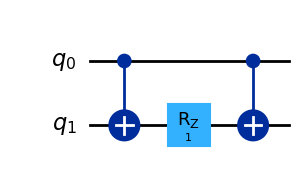

In [4]:
circ = QuantumCircuit(2)
circ.cx(0,1)
circ.rz(1,1)
circ.cx(0,1)
circ.draw(output='mpl',style='iqx')

It is easy to generalize to multiple qubit systems  
For example $\exp[-i\frac\theta 2 (\sigma_z \otimes \sigma_z \otimes \sigma_z)]$:

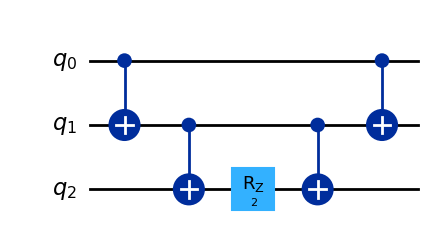

In [5]:
circ = QuantumCircuit(3)
circ.cx(0,1)
circ.cx(1,2)
circ.rz(2,2)
circ.cx(1,2)
circ.cx(0,1)
circ.draw(output='mpl',style='iqx')

In [6]:
result = vqe.compute_minimum_eigenvalue(H2_op)
print(result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 75,
    'eigenvalue': -1.8572749929952035,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x7f11c1bd3760>,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): 1.5176746135677284,
                              ParameterVectorElement(θ[1]): -1.319498750037169,
                              ParameterVectorElement(θ[2]): -0.08121129987745176,
                              ParameterVectorElement(θ[3]): 0.41571192265368573,
                              ParameterVectorElement(θ[4]): 0.3769096811079118,
                              ParameterVectorElement(θ[5]): -5.371884465834617,
                              ParameterVectorElement(θ[6]): -4.97746705405553,
                              ParameterVectorElement(θ[7]): -6.855205073333374},
    'optimal_point': array([ 1.51767461, -1.31949875, -0.0812113 ,  0.41571192,  0.37690968,
       -5.37188447, -4.97746705, -6.85520507]),
    'opt

# Supplementary on Optimization Algorithms

## Sequential Least Squares Quadratic Programming (SLSQP)
> [[Kraft, 1998]](http://degenerateconic.com/uploads/2018/03/DFVLR_FB_88_28.pdf)  
    A software package for sequential quadratic programming.  
    Tech. Rep. DFVLR-FB 88-28, DLR German Aerospace Center —  
    Institute for Flight Mechanics, Koln, Germany. 

An iterative method for constrained nonlinear optimization.
SQP methods solvea sequence of optimization subproblems,
each of which optimizes a quadratic model of the objecive subject to a linearization of constraints.
* The problem: $\min_x f(x)$
* Subject to constraints
    * $h(x) \geq 0$
    * $g(x) = 0$
* The *Lagrangian* for this problem: $\mathcal{L}(x,\lambda,\sigma) = f(x) - \lambda h(x) - \sigma g(x)$ ($\lambda,\sigma$ are Lagrange multipliers)  
    * The idea of Lagrange multipliers: $\nabla f$ is the direction of which the value of $f$ changes.
$\nabla g$ is the direction of which the value of the constraint changes. Since $g(\mathbf{x})=0$ must be satisfied, this direction is *forbidden*.
The condition $\nabla\mathcal{L} = \nabla(f - \lambda g) = 0$ is satisified at the stationary point. This statement suggests $\nabla_x f - \nabla_x g = 0$ and $\nabla_\lambda \mathcal{L} = 0 \rightarrow g = 0$
Equivalently $\nabla f = \nabla g$, there exists no direction that can both satisify $g$ and change the value of $f$, thus a stationary point.
* Target: To find a stationary point of $f(x)$ by method of Lagrange multipliers $\nabla \mathcal{L}=0$
The algorithm: ($\nabla^2_{xx}$ denotes the Hessian matrix):

$$
\begin{bmatrix}
x_{k+1} \\
\lambda_{k+1} \\
\sigma_{k+1}
\end{bmatrix}= 
\begin{bmatrix}
x_{k} \\
\lambda_{k} \\
\sigma_{k}
\end{bmatrix} -
\underbrace{
\begin{bmatrix}
\nabla_{xx}^2 \mathcal{L} & \nabla h & \nabla h \\
\nabla h^T & 0 & 0 \\
\nabla g^T & 0 & 0
\end{bmatrix}^{-1}}_{\nabla^2 \mathcal{L}} \:
\underbrace{
\begin{bmatrix}
\nabla f + \lambda_k \nabla h + \sigma_k \nabla g \\
h \\
g \\
\end{bmatrix}}_{\nabla \mathcal{L}}
$$

The meaning of this equation is essentially $\mathcal{L}_{k+1} - \mathcal{L}_k = -\nabla\mathcal{L}/\nabla^2\mathcal{L}$, which resembles *Newton's method* for optimization.
Since $\nabla^2 \mathcal{L}$ is in general non-invertable, the algorithm solves for a suitable *Newton step*
$d_k = (\nabla^2_{xx}\mathcal{L})^{-1}\nabla\mathcal{L}$, which is the solution to the *quadratic programming subproblem*
$$\begin{align*}
\min_d & f(x_k) + \nabla f(x_k)^T d + \frac12 d^T \nabla^2_{xx}\mathcal{L}(x_k,\lambda_k,\sigma_k)d \\
\text{such that } & h(x_k) + \nabla h(x_k)^T d \geq 0 \\
& g(x_k) + \nabla g(x_k)^T d = 0
\end{align*}
$$
At each iteration $d_k$ is solved, and the value is updated $[x_{k+1},\lambda_{k+1},\sigma_{k+1}]^T = [x_k, \lambda_k , \sigma_k]^T + d_k$.

## Constrained optimization by linear approximation (`COBYLA`)
> [[Powell, 2007]](http://www.damtp.cam.ac.uk/user/na/NA_papers/NA2007_03.pdf) A view of algorithms for optimization without derivatives  
> [[Powell, 1998]](https://www.cambridge.org/core/journals/acta-numerica/article/abs/direct-search-algorithms-for-optimization-calculations/23FA5B19EAF122E02D3724DB1841238C#) Direct search algorithms for optimization calculations  
> [COBYLA Source](https://www.zhangzk.net/software.html#cobyla)  
 
### Simplex methods
Roughly speaking, a simplex of dimension $n$ is a convex hull with $n+1$ vertices.  
The objective is to find the minimum value of $F(\mathbf{x}), \mathbf{x}\in\mathbb{R}^n$.  
Consider $F(\mathbf{x}_0)\leq F(\mathbf{x}_1) \leq \dots \leq F(\mathbf{x}_n)$  
Assume the volume of the simplex with vertices $\mathbf{x}_0, \mathbf{x}_1,\dots,\mathbf{x}_n$ is non-zero  
The simplex method calculates the new function value $F(\hat{\mathbf{x}})$, where $\hat{\mathbf{x}}$ is the point
$$
\hat{\mathbf{x}} = \frac2n\sum_{i=0}^{n-1}(\mathbf{x}_i - \mathbf{x}_n)
$$
If $F(\hat{\mathbf{x}})<F(\mathbf{x}_{n-1})$ then $\mathbf{x}$ replaces vertex $\mathbf{x}_n$.  
Otherwise replace $\mathbf{x}_i$ where $i=1\dots n$ by $(\mathbf{x}_0+\mathbf{x}_i)/2$



... to be completed...

# Advanced VQE Options

Implementation of a callback convergence monitor, using custom `initial points` and `gradient`s.

In [7]:
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit_algorithms.utils import algorithm_globals
# we will iterate over these different optimizers
optimizers = [COBYLA(maxiter=80), L_BFGS_B(maxiter=60), SLSQP(maxiter=60)]
converge_counts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

for i, optimizer in enumerate(optimizers):
    print("\rOptimizer: {}        ".format(type(optimizer).__name__), end="")
    algorithm_globals.random_seed = 50
    ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")

    counts = []
    values = []

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe = VQE(estimator, ansatz, optimizer, callback=store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(operator=H2_op)
    converge_counts[i] = np.asarray(counts)
    converge_vals[i] = np.asarray(values)

print("\rOptimization complete      ");

Optimization complete      


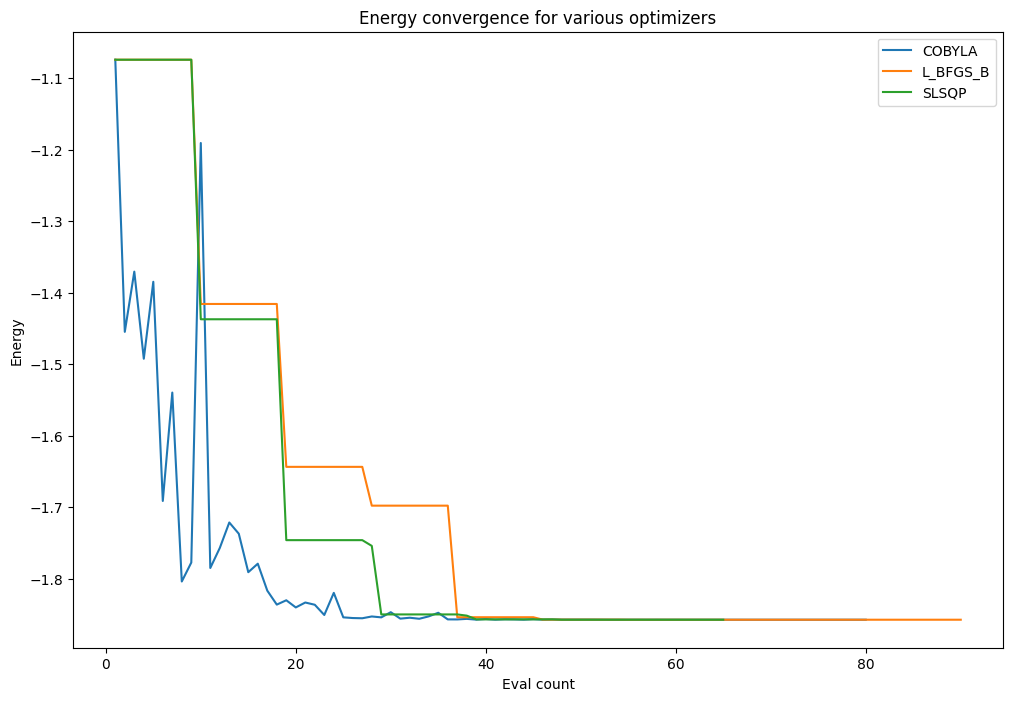

In [8]:
import pylab

pylab.rcParams["figure.figsize"] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_counts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence for various optimizers")
pylab.legend(loc="upper right");

In [9]:
from qiskit_algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f"Reference value: {ref_value:.5f}")

Reference value: -1.85728


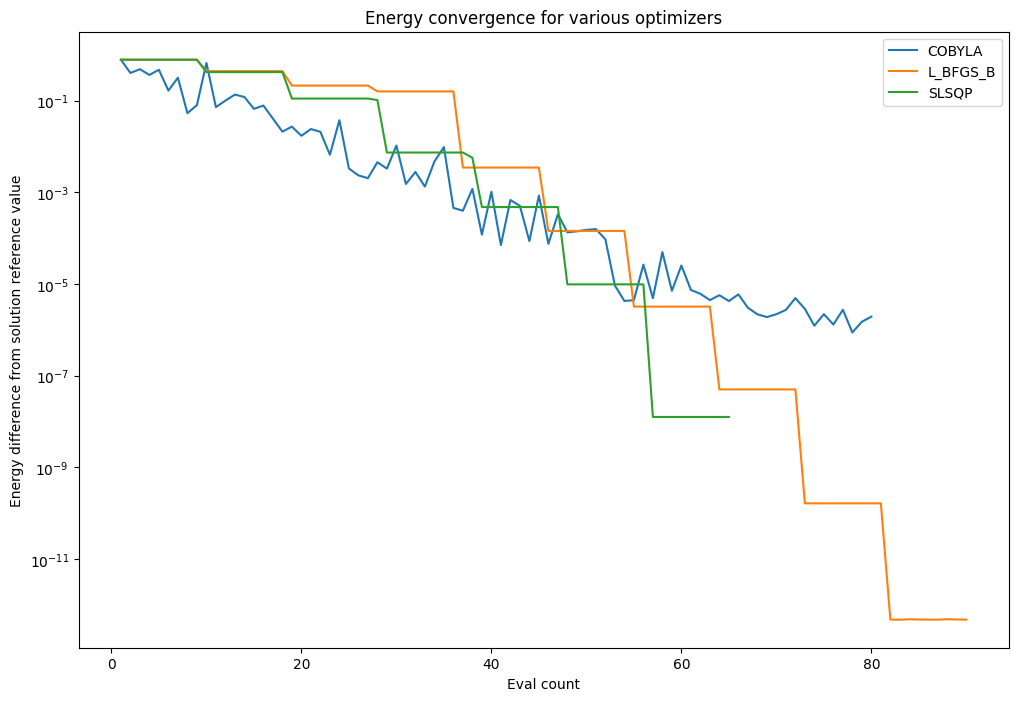

In [10]:


pylab.rcParams["figure.figsize"] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(
        converge_counts[i],
        abs(ref_value - converge_vals[i]),
        label=type(optimizer).__name__,
    )
pylab.xlabel("Eval count")
pylab.ylabel("Energy difference from solution reference value")
pylab.title("Energy convergence for various optimizers")
pylab.yscale("log")
pylab.legend(loc="upper right");



Value using Gradient: -1.85728


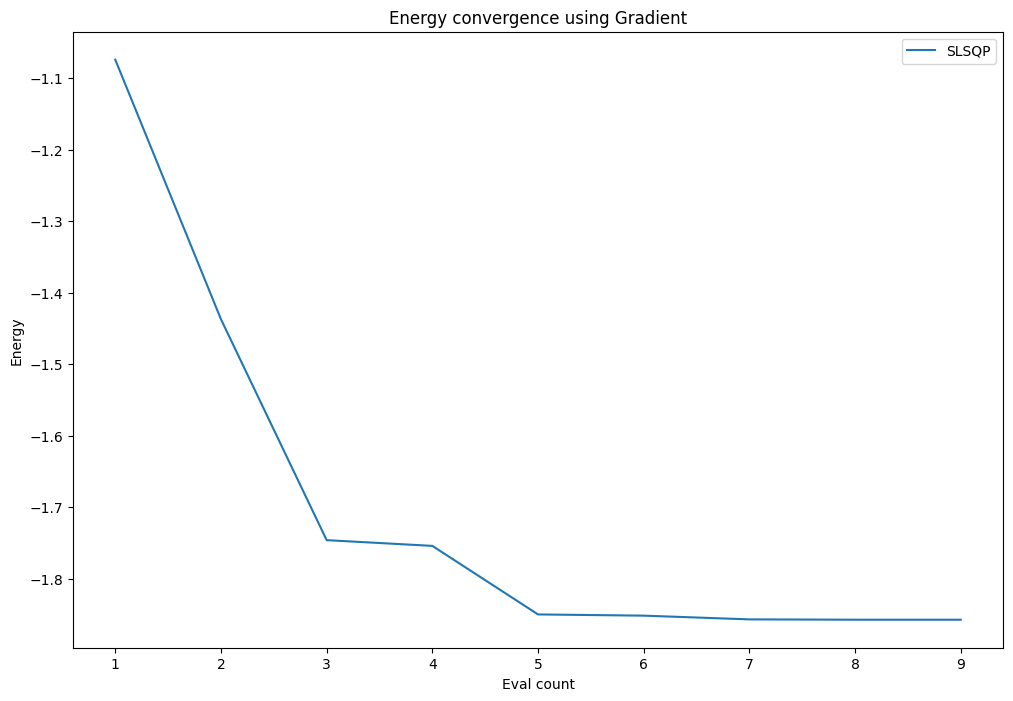

In [12]:
from qiskit_algorithms.gradients import FiniteDiffEstimatorGradient

estimator = Estimator()
gradient = FiniteDiffEstimatorGradient(estimator, epsilon=0.01)
algorithm_globals.random_seed = 50
ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")

optimizer = SLSQP(maxiter=100)

counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)


vqe = VQE(
    estimator, ansatz, optimizer, callback=store_intermediate_result, gradient=gradient
)

result = vqe.compute_minimum_eigenvalue(operator=H2_op)
print(f"Value using Gradient: {result.eigenvalue.real:.5f}")
pylab.rcParams["figure.figsize"] = (12, 8)
pylab.plot(counts, values, label=type(optimizer).__name__)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence using Gradient")
pylab.legend(loc="upper right");

In [13]:
initial_pt = result.optimal_point

estimator1 = Estimator()
gradient1 = FiniteDiffEstimatorGradient(estimator, epsilon=0.01)
ansatz1 = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
optimizer1 = SLSQP(maxiter=1000)

vqe1 = VQE(
    estimator1, ansatz1, optimizer1, gradient=gradient1, initial_point=initial_pt
)
result1 = vqe1.compute_minimum_eigenvalue(operator=H2_op)
print(result1)

cost_function_evals1 = result1.cost_function_evals
print()

{   'aux_operators_evaluated': None,
    'cost_function_evals': 1,
    'eigenvalue': -1.8572750175655814,
    'optimal_circuit': <qiskit.circuit.library.n_local.two_local.TwoLocal object at 0x7f113a77feb0>,
    'optimal_parameters': {   ParameterVectorElement(θ[1]): 4.426962358395488,
                              ParameterVectorElement(θ[0]): 4.296519450348827,
                              ParameterVectorElement(θ[7]): 0.36021017470907635,
                              ParameterVectorElement(θ[4]): -2.598326651673366,
                              ParameterVectorElement(θ[2]): 0.547077760765989,
                              ParameterVectorElement(θ[6]): -4.71761614744971,
                              ParameterVectorElement(θ[5]): 1.5683250498282786,
                              ParameterVectorElement(θ[3]): 6.092947832767062},
    'optimal_point': array([ 4.29651945,  4.42696236,  0.54707776,  6.09294783, -2.59832665,
        1.56832505, -4.71761615,  0.36021017]),
    'optimal_va

# VQE with Qiskit Aer Primitives

In [14]:
from qiskit.quantum_info import SparsePauliOp

H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

print(f"Number of qubits: {H2_op.num_qubits}")



Number of qubits: 2


In [15]:
from qiskit_algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f"Reference value: {ref_value:.5f}")

Reference value: -1.85728


/tmp/ipykernel_85435/1225149183.py:23: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstmator from qiskit.primitives.
  noiseless_estimator = AerEstimator(


VQE on Aer qasm simulator (no noise): -1.85160
Delta from reference energy value is 0.00567


Text(0.5, 1.0, 'Convergence with no noise')

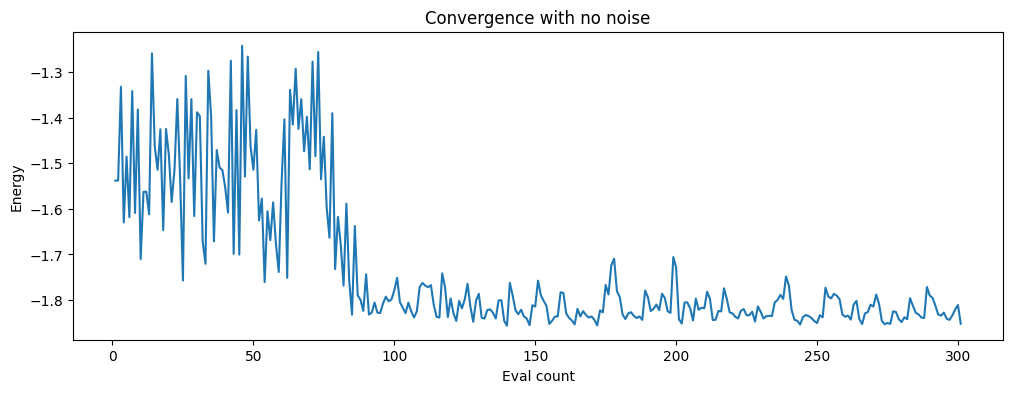

In [18]:
# define ansatz and optimizer
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms.optimizers import SPSA

iterations = 125
ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
spsa = SPSA(maxiter=iterations)
# define callback
# note: Re-run this cell to restart lists before training
counts = []
values = []

def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)
# define Aer Estimator for noiseless statevector simulation
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator

seed = 170
algorithm_globals.random_seed = seed

noiseless_estimator = AerEstimator(
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)
# instantiate and run VQE
from qiskit_algorithms import VQE

vqe = VQE(
    noiseless_estimator, ansatz, optimizer=spsa, callback=store_intermediate_result
)
result = vqe.compute_minimum_eigenvalue(operator=H2_op)

print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(
    f"Delta from reference energy value is {(result.eigenvalue.real - ref_value):.5f}"
)
import pylab

pylab.rcParams["figure.figsize"] = (12, 4)
pylab.plot(counts, values)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Convergence with no noise")



In [19]:
from qiskit_aer.noise import NoiseModel
from qiskit.providers.fake_provider import FakeVigo

# fake providers contain data from real IBM Quantum devices stored in Qiskit,
# and are useful for extracting realistic noise models.
device = FakeVigo()

coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)

print(noise_model)


NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['cx', 'x', 'id', 'measure', 'sx']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('sx', (4,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('x', (4,)), ('cx', (3, 4)), ('cx', (4, 3)), ('cx', (3, 1)), ('cx', (1, 3)), ('cx', (1, 2)), ('cx', (2, 1)), ('cx', (0, 1)), ('cx', (1, 0)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('measure', (4,))]


In [22]:
noisy_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": 1024},
    transpile_options={"seed_transpiler": seed},
)
# re-start callback variables
counts = []
values = []

vqe.estimator = noisy_estimator

result1 = vqe.compute_minimum_eigenvalue(operator=H2_op)

print(f"VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.5f}")
print(
    f"Delta from reference energy value is {(result1.eigenvalue.real - ref_value):.5f}"
)

/tmp/ipykernel_85435/3595522659.py:1: DeprecationWarning: Option approximation=False is deprecated as of qiskit-aer 0.13. It will be removed no earlier than 3 months after the release date. Instead, use BackendEstmator from qiskit.primitives.
  noisy_estimator = AerEstimator(


VQE on Aer qasm simulator (with noise): -1.75849
Delta from reference energy value is 0.09879


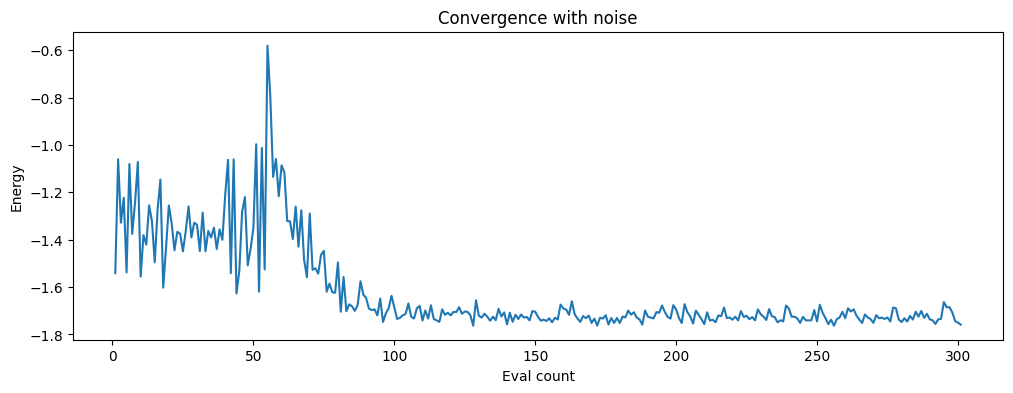

In [23]:
if counts or values:
    pylab.rcParams["figure.figsize"] = (12, 4)
    pylab.plot(counts, values)
    pylab.xlabel("Eval count")
    pylab.ylabel("Energy")
    pylab.title("Convergence with noise")

In [25]:
print(f"Reference value: {ref_value:.5f}")
print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(f"VQE on Aer qasm simulator (with noise): {result1.eigenvalue.real:.5f}")


Reference value: -1.85728
VQE on Aer qasm simulator (no noise): -1.85160
VQE on Aer qasm simulator (with noise): -1.75849


# Grover's Algorithm and Amplitude Amplificaition 

# Quantum Real Time Evolution Using Trotterization